In [1]:
from utils.CoopEnv import CoopEnv
from utils.IACagent import Agent
from utils.Sagent import Agent2

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set constant hyperparameters
n_learner = 10
n_simple = 0
n = n_learner + n_simple
num_of_tasks  = 9
num_of_sims = 1
step_limit = 10000

In [4]:
move_space = num_of_tasks

lower_bound = -.99
upper_bound = 2
comm_array = np.arange(start=lower_bound, stop=upper_bound+0.01, step=0.01)

comm_space = len(comm_array)
print(comm_space)

300


In [5]:
env = CoopEnv(n=n, num_of_tasks=num_of_tasks)

In [6]:
steps_to_complete = np.zeros((num_of_sims, step_limit+1))
recorded_rewards = np.zeros((step_limit+1, env.n))
comm_rec_actions = np.zeros((step_limit, env.n))
move_rec_actions = np.zeros((step_limit, env.n))

In [7]:
def main():

    for s in range(num_of_sims):

        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")

        # reinitialise agent list each sim
        agentlist_learner = {i: Agent(move_space, comm_space) for i in range(n_learner)}
        agentlist_simple = {j: Agent2(move_space, comm_space) for j in range(n_simple)}
        # reset the environment
        observations = env.reset(n=n, num_of_tasks =num_of_tasks)

        # begin training loop
        t = 0
        while t < step_limit:
            print(t, end='\r')

            # Choose actions (learner)
            if n_learner > 0:
                actions_learner = np.zeros((n_learner, 2)) # column 0 for move actions and column 1 for comm actions
                actions_learner = np.array([agentlist_learner[i].choose_action(observations[i]) for i in range(n_learner)])
            # Choose actions (simple)
            if n_simple > 0:
                actions_simple = np.zeros((n_simple, 2))
                actions_simple = np.array([agentlist_simple[j].select_arm() for j in range(n_simple)])

            if n_simple >0 and n_learner > 0:
                sys_actions = np.vstack((actions_learner, actions_simple))

            elif n_learner > 0 and n_simple == 0:
                sys_actions = actions_learner
            else:
                sys_actions = actions_simple


            action_move = sys_actions[:,0]
            action_comm = comm_array[sys_actions[:,1]]

            next_observations, rewards, termination, info = env.step(action_move, action_comm) # env.step


            comm_rec_actions[t] = action_comm  # output from actor (comm head)
            move_rec_actions[t] = action_move

            for i in range(n_learner): # train each agent
                agentlist_learner[i].train(observations[i], sys_actions[i, :], rewards[i], next_observations[i])
            for j in range(n_simple): # train simple agents
                agentlist_simple[j].update(sys_actions[n_learner+j, 0]*comm_space+sys_actions[n_learner+j, 1], rewards[n_learner+j])

            # advance state
            observations = next_observations
            # record average system reward score
            steps_to_complete[s, t+1] = (sum(rewards)/n) + steps_to_complete[s, t]
            recorded_rewards[t+1, :] = rewards + recorded_rewards[t, :]

            # increment timestep and loop
            t +=1




In [8]:
if __name__ == "__main__":

    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------


KeyboardInterrupt: 

In [ ]:
np.save(f'n{n}t{num_of_tasks}_cum_rew_mixed{n_learner},{n_simple}', steps_to_complete)
np.save(f'n{n}t{num_of_tasks}_actions_mixed{n_learner},{n_simple}', comm_rec_actions)

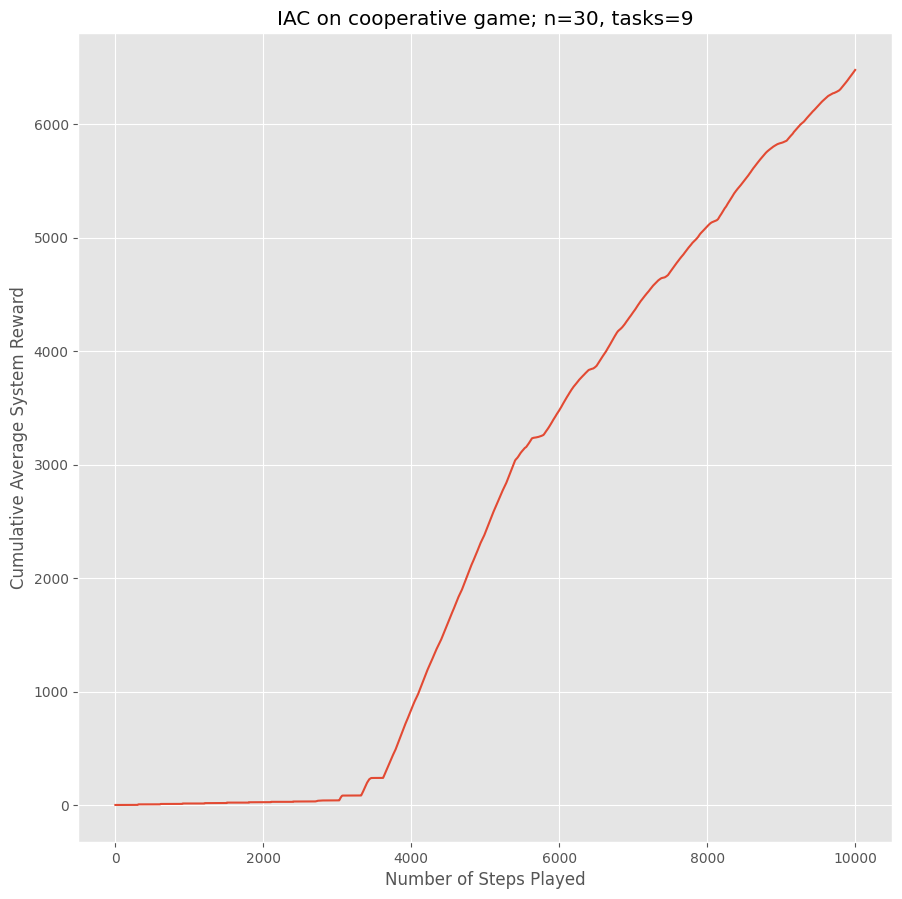

In [ ]:
plt.style.use('ggplot')
b = np.mean(steps_to_complete, axis=0)
s_dev = np.std(steps_to_complete, axis=0)
plt.xlabel('Number of Steps Played')
plt.ylabel('Cumulative Average System Reward')
plt.title(f'IAC on cooperative game; n={n}, tasks={num_of_tasks}')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(b)

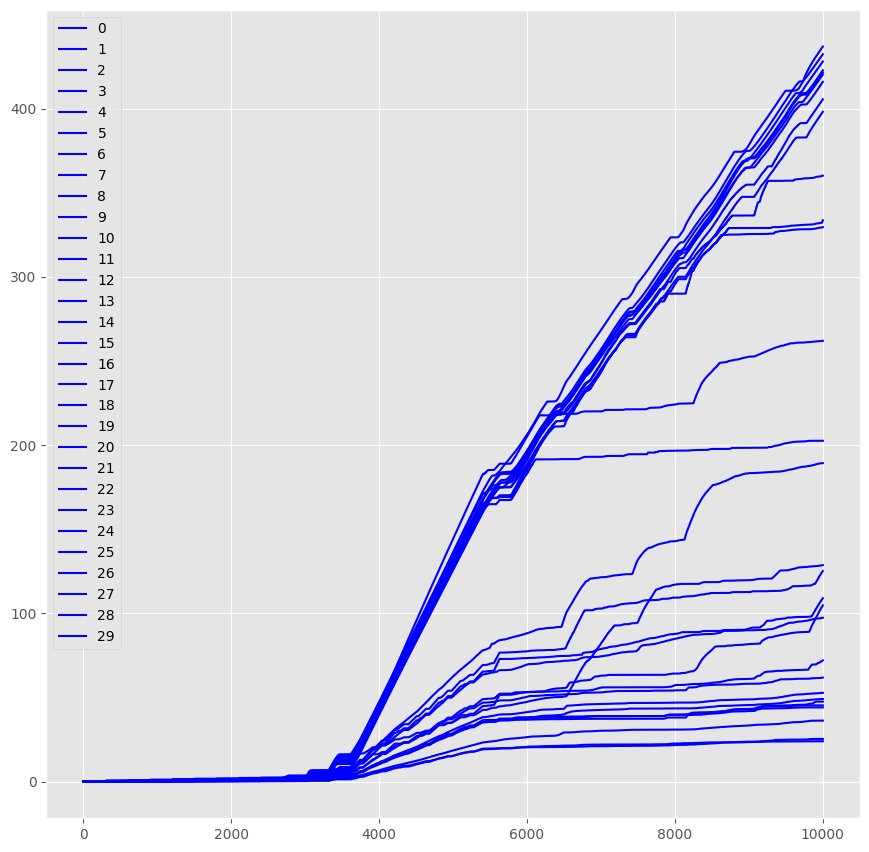

In [ ]:
c = recorded_rewards/env.n

for i in range(env.n):
    if i<n_learner:
        plt.plot(c[:,i], label=f'{i}', color='r')
    if i>=n_learner:
        plt.plot(c[:,i], label=f'{i}', color='b')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.legend()

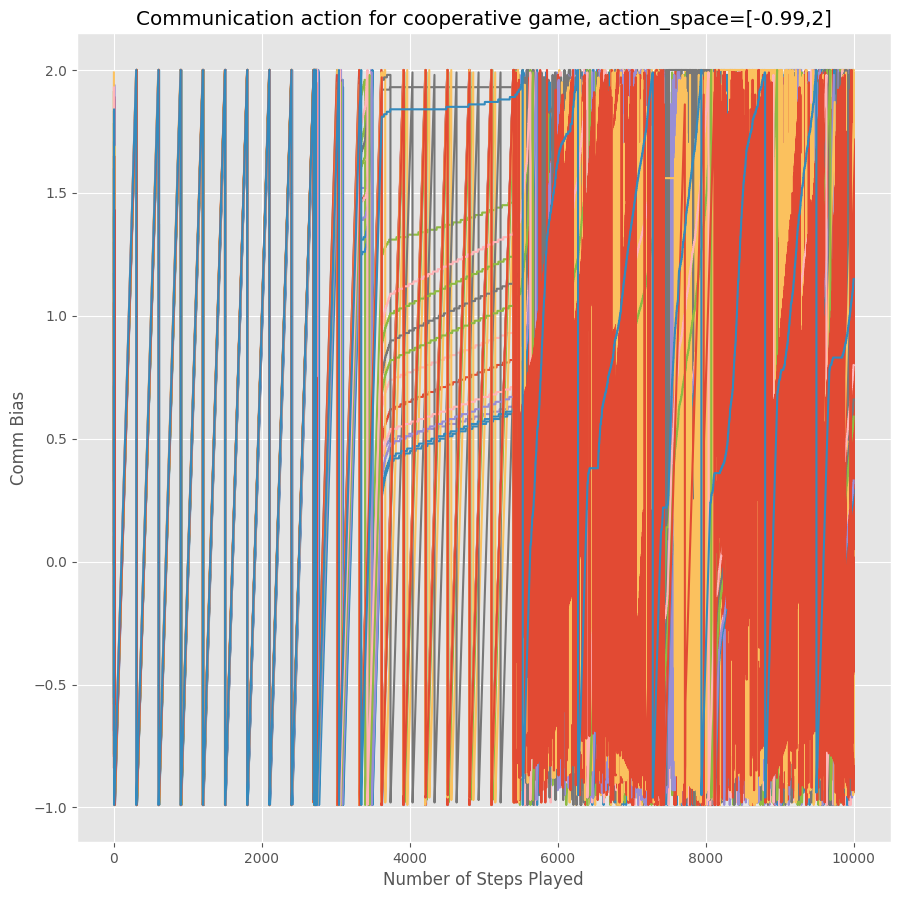

In [ ]:
plt.xlabel('Number of Steps Played')
plt.ylabel('Comm Bias')
plt.title(f'Communication action for cooperative game, action_space=[{lower_bound},{upper_bound}]')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

plt.plot(comm_rec_actions)

In [ ]:
# Get coalition structure
converged_structure = np.zeros((num_of_tasks, env.n))
task = 0
for C in env.CS:
    indices = [int(a)-1 for a in list(C)]
    converged_structure[task, indices] = 1
    task+=1

print(converged_structure)
np.save(f'n{n}t{num_of_tasks}_cstruct_mixed{n_learner},{n_simple}.npy', converged_structure)
print(env.CS)

[[0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1.
  1. 0. 1. 1. 0. 1.]]
[{'4', '9', '5', '15'}, {'2', '26'}, {'3'}, {'1', '11', '17'}, set(), {'29', '6', '22', '14'}, {'19'}, {'18'}, {'27', '21', '7', '16', '23', '13